In [102]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from operator import add
from dotenv import load_dotenv
import google.generativeai as genai
import os
from pydantic import BaseModel, Field
import operator

In [103]:
load_dotenv()

True

In [104]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    api_key=os.getenv("GEMINI_API_KEY")
)

In [105]:
class EvaluationSchema(BaseModel):
    feedback:str = Field(description='Detailed feedback for the essay.')
    score:int = Field(description='Score out of 10',ge=0,le=10)

In [106]:
structured_model = model.with_structured_output(EvaluationSchema)

In [107]:
def append_reducer(left: list[int], right: int | list[int]) -> list[int]:
    if isinstance(right, int):
        return left + [right]
    return left + right


In [139]:
class UPSCState(TypedDict):
    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[int, operator.add]  #Reducer Function 'add' will append the items in the list instead of replacing
    # Its like a [x] + [y] + [z] = [x,y,z]
    avg_score:float

In [169]:
def evaluate_language(state:UPSCState):
    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    print(output.score)
    return {'language_feedback' : output.feedback, 'individual_scores' : output.score}

In [170]:
def evaluate_analysis(state:UPSCState):
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    return {'analysis_feedback' : output.feedback, 'individual_scores' : output.score}

In [171]:
def evaluate_thought(state:UPSCState):
    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)
    return {'clarity_feedback' : output.feedback, 'individual_scores' : output.score}

In [172]:
def final_evaluation(state:UPSCState):
    #Summary feedback
    prompt = f"Based on the following feedbacks create a summarized feedback \n language - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt).content
    
    #Average score
    avg_score = state['individual_scores']/3
    # avg_score = state['individual_scores']
    return {'overall_feedback': overall_feedback,'avg_score':avg_score}

In [173]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)

graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')
graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')
graph.add_edge('evaluate_language',END)

workflow = graph.compile()

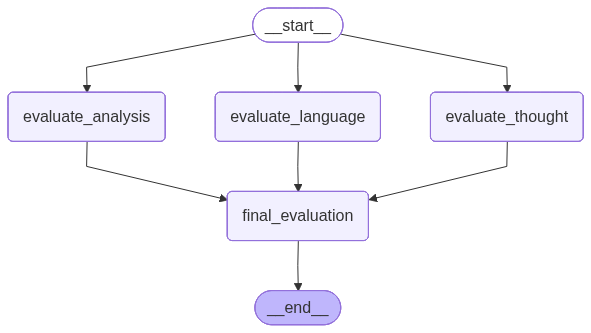

In [174]:
workflow

In [175]:
essay = """
Artificial Intelligence (AI) agents are one of the most trending topics in today’s world, as they are reshaping the way we work, learn, and interact with technology. An AI agent is a system that can act on its own, analyze situations, and take decisions to achieve specific goals. Unlike traditional tools that only follow direct instructions, agents can adapt, improve, and even collaborate with humans or other agents. This makes them highly valuable across many fields, from business to healthcare and education.

In the workplace, AI agents are helping automate repetitive tasks such as answering basic customer queries, analyzing data, or scheduling activities. This allows people to focus more on creative and complex work. They also provide personalized experiences, such as tailoring recommendations or learning materials to an individual’s needs. At the same time, their ability to handle large amounts of information makes them powerful decision-making partners for managers and professionals.

However, AI agents also bring challenges, including job displacement, data privacy concerns, and the risk of bias in decision-making. To use them responsibly, humans must remain in control and ensure fairness and accountability. If used wisely, AI agents could lead to a future where technology and human effort grow together.
"""

In [176]:
initial_state = {
    'essay' : essay
}
workflow.invoke(initial_state)

9


{'essay': '\nArtificial Intelligence (AI) agents are one of the most trending topics in today’s world, as they are reshaping the way we work, learn, and interact with technology. An AI agent is a system that can act on its own, analyze situations, and take decisions to achieve specific goals. Unlike traditional tools that only follow direct instructions, agents can adapt, improve, and even collaborate with humans or other agents. This makes them highly valuable across many fields, from business to healthcare and education.\n\nIn the workplace, AI agents are helping automate repetitive tasks such as answering basic customer queries, analyzing data, or scheduling activities. This allows people to focus more on creative and complex work. They also provide personalized experiences, such as tailoring recommendations or learning materials to an individual’s needs. At the same time, their ability to handle large amounts of information makes them powerful decision-making partners for managers 